In [66]:
import os, shutil, pathlib
import json
import keras
from keras import ops
import keras_hub

In [67]:
# preparing Metadata
os.environ["KERAS_BACKEND"] = "jax"
images_path ="coco_dataset/datasets/coco/"
annotations_path="coco_dataset/datasets/annotations/annotations/"

In [68]:
with open(f"{annotations_path}instances_train2017.json", "r") as f:
    annotations = json.load(f)

images = {image["id"]: image for image in annotations["images"]}

In [69]:
def scale_box(box, width, height):
    scale = 1.0 / max(width, height)
    x, y, w, h = [v * scale for v in box]
    x += (height - width) * scale / 2 if height > width else 0
    y += (width - height) * scale / 2 if width > height else 0
    return [x, y, w, h]

metadata = {}
for annotation in annotations["annotations"]:
    id = annotation["image_id"]
    if id not in metadata:
        metadata[id] = {"boxes": [], "labels": []}
    image = images[id]
    box = scale_box(annotation["bbox"], image["width"], image["height"])
    metadata[id]["boxes"].append(box)
    metadata[id]["labels"].append(annotation["category_id"])
    metadata[id]["path"] = images_path + "train2017/" + image["file_name"]
metadata = list(metadata.values())

In [70]:
# Maping Labels id to Names 
[keras_hub.utils.coco_id_to_name(x) for x in metadata[433]["labels"]]

['cat', 'toilet']

In [71]:
# functions for visualization of Image, boxes, labels with color
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x, y, text, c="white", size=10, va="bottom", bbox=textbox)

def draw_image(ax, image):
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)

In [72]:
# Load custom YOLO model (redefine custom functions/loss for load)

from keras import layers

grid_size = 6
num_labels = 91

In [73]:
# functions required to Load custom YOLO model
def signed_sqrt(x):
    return ops.sign(x) * ops.sqrt(ops.absolute(x) + keras.config.epsilon())

def unpack(box):
    return box[..., 0], box[..., 1], box[..., 2], box[..., 3]

def intersection(box1, box2):
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    left = ops.maximum(cx1 - w1 / 2, cx2 - w2 / 2)
    bottom = ops.maximum(cy1 - h1 / 2, cy2 - h2 / 2)
    right = ops.minimum(cx1 + w1 / 2, cx2 + w2 / 2)
    top = ops.minimum(cy1 + h1 / 2, cy2 + h2 / 2)
    return ops.maximum(0.0, right - left) * ops.maximum(0.0, top - bottom)

def intersection_over_union(box1, box2):
    intersection_area = intersection(box1, box2)
    cx1, cy1, w1, h1 = unpack(box1)
    cx2, cy2, w2, h2 = unpack(box2)
    a1 = ops.maximum(w1, 0.0) * ops.maximum(h1, 0.0)
    a2 = ops.maximum(w2, 0.0) * ops.maximum(h2, 0.0)
    union_area = a1 + a2 - intersection_area
    return ops.divide_no_nan(intersection_area, union_area)

def box_loss(true, pred):
    xy_true, wh_true, conf_true = true[..., :2], true[..., 2:4], true[..., 4:]
    xy_pred, wh_pred, conf_pred = pred[..., :2], pred[..., 2:4], pred[..., 4:]
    no_object = conf_true == 0.0
    xy_error = ops.square(xy_true - xy_pred)
    wh_error = ops.square(signed_sqrt(wh_true) - signed_sqrt(wh_pred))
    iou = intersection_over_union(true, pred)
    conf_target = ops.where(no_object, 0.0, ops.expand_dims(iou, -1))
    conf_error = ops.square(conf_target - conf_pred)
    error = ops.concatenate(
        (
            ops.where(no_object, 0.0, xy_error * 5.0),
            ops.where(no_object, 0.0, wh_error * 5.0),
            ops.where(no_object, conf_error * 0.5, conf_error),
        ),
        axis=-1,
    )
    return ops.sum(error, axis=(1, 2, 3))

In [74]:
# Load custom model
custom_model = keras.models.load_model('trained_yolo_model.keras', custom_objects={'box_loss': box_loss})
print("Custom YOLO loaded.")

Custom YOLO loaded.


In [75]:
#Output Prediction
def to_grid(box):
    x, y, w, h = box
    cx, cy = (x + w / 2) * grid_size, (y + h / 2) * grid_size
    ix, iy = int(cx), int(cy)
    return (ix, iy), (cx - ix, cy - iy, w, h)

def from_grid(loc, box):
    (xi, yi), (x, y, w, h) = loc, box
    x = (xi + x) / grid_size - w / 2
    y = (yi + y) / grid_size - h / 2
    return (x, y, w, h)


In [76]:
# taking count of unique values of lebal more than 6
import random
from collections import Counter
metadata = [x for x in metadata if len(set(tuple(box) for box in x["boxes"])) > 6]
random.shuffle(metadata)

In [77]:
import numpy as np
import math

class_array = np.zeros((len(metadata), grid_size, grid_size))
box_array = np.zeros((len(metadata), grid_size, grid_size, 5))

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (x, y, w, h) = box
        left, right = math.floor(x * grid_size), math.ceil((x + w) * grid_size)
        bottom, top = math.floor(y * grid_size), math.ceil((y + h) * grid_size)
        class_array[index, bottom:top, left:right] = label

for index, sample in enumerate(metadata):
    boxes, labels = sample["boxes"], sample["labels"]
    for box, label in zip(boxes, labels):
        (xi, yi), (grid_box) = to_grid(box)
        box_array[index, yi, xi] = [*grid_box, 1.0]
        class_array[index, yi, xi] = label

In [78]:
def draw_prediction(image, boxes, classes, cutoff=None):
    fig, ax = plt.subplots(dpi=300)
    draw_image(ax, image)
    for yi, row in enumerate(classes):
        for xi, label in enumerate(row):
            color = label_to_color(label) if label else "none"
            x, y, w, h = (v / grid_size for v in (xi, yi, 1.0, 1.0))
            r = Rectangle((x, y), w, h, lw=2, ec="black", fc=color, alpha=0.5)
            ax.add_patch(r)
    for yi, row in enumerate(boxes):
        for xi, box in enumerate(row):
            box, confidence = box[:4], box[4]
            if not cutoff or confidence >= cutoff:
                box = from_grid((xi, yi), box)
                label = classes[yi, xi]
                color = label_to_color(label)
                name = keras_hub.utils.coco_id_to_name(label)
                draw_box(ax, box, f"{name} {max(confidence, 0):.2f}", color)
    plt.show()

In [91]:
# '000000019489.jpg' is our test image

target_path = 'coco_dataset/datasets/coco/train2017/000000019489.jpg'

# Find the index
for i, item in enumerate(metadata):
    if item['path'] == target_path:
        found_index = i
        print(f"Found at index {i}: {item}")
        break
else:
    print("Not found")

Found at index 37257: {'boxes': [[0.091234375, 0.569546875, 0.9018750000000001, 0.23781249999999998], [0.7050468750000001, 0.5797656250000001, 0.06853125, 0.1213125], [0.3253125, 0.61565625, 0.19846875, 0.21637499999999998], [0.7103281250000001, 0.5082031250000001, 0.27159375, 0.323828125], [0.002984375, 0.24706250000000002, 0.12534375, 0.57303125], [0.37868750000000007, 0.4344375, 0.068734375, 0.08904687500000001], [0.42978125, 0.290328125, 0.285015625, 0.5178281250000001], [0.728234375, 0.33809374999999997, 0.076109375, 0.19846875], [0.8356718750000001, 0.36234375, 0.14028125, 0.34023437500000003], [0.7100312500000001, 0.36928125, 0.048906250000000005, 0.09412500000000001], [0.6675312500000001, 0.40890625, 0.065140625, 0.12565625], [0.16718750000000002, 0.271875, 0.29765625, 0.56015625], [0.114546875, 0.43245312500000005, 0.079015625, 0.233203125], [0.8232187500000001, 0.35121875, 0.066859375, 0.17895312500000002], [0.9603125000000001, 0.39001562500000003, 0.0396875, 0.200984375], [0

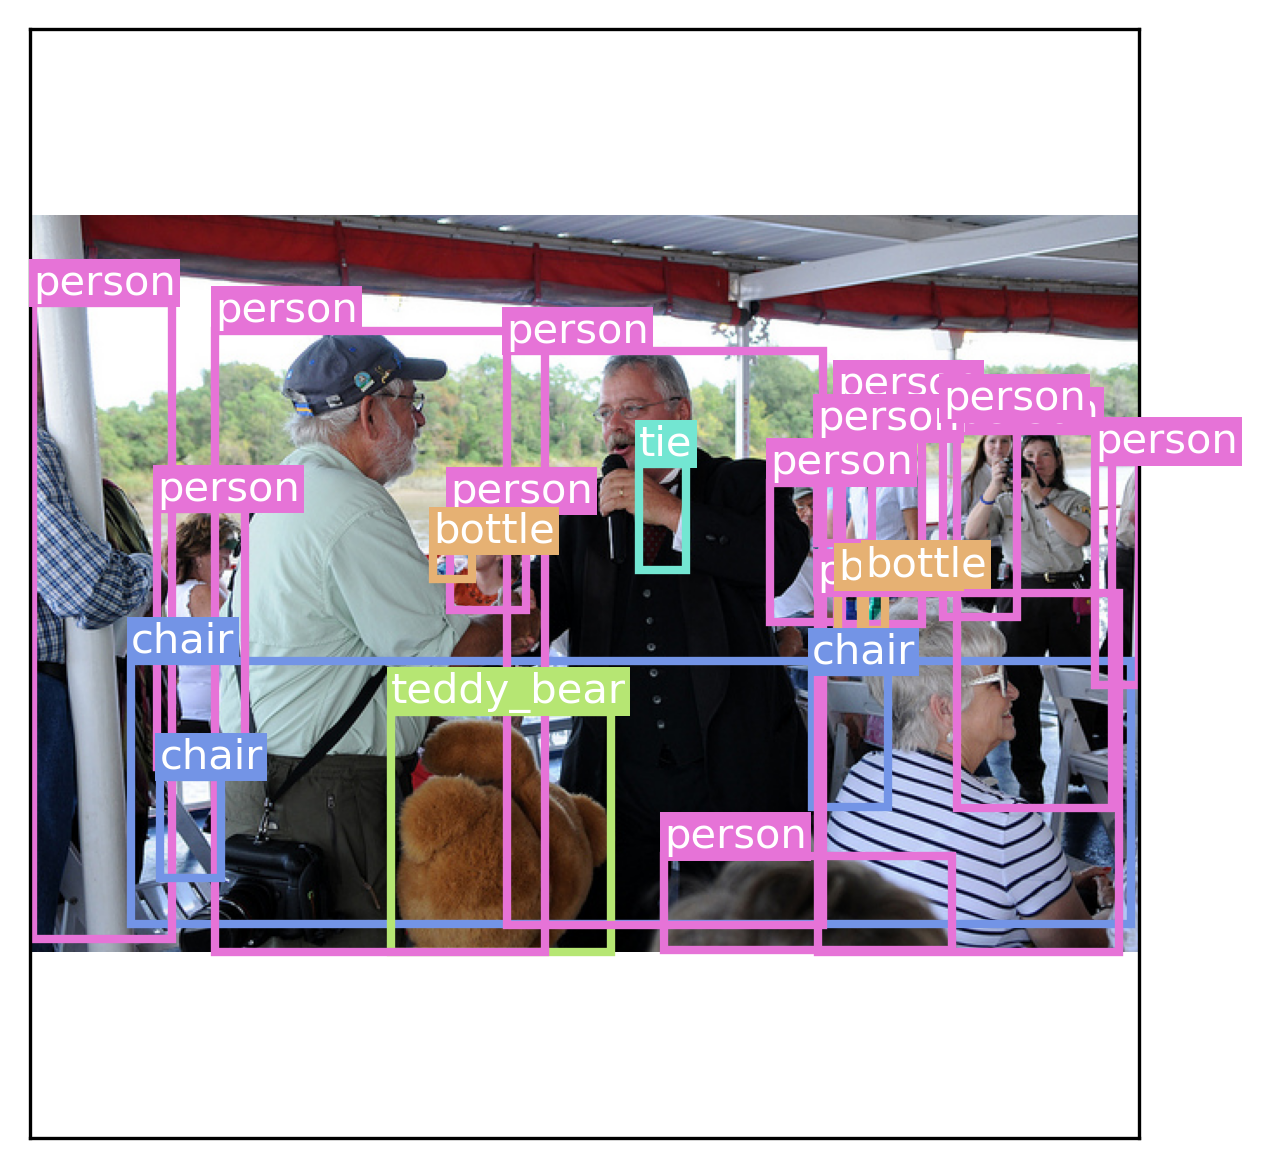

In [92]:
# visualizing an Image
sample = metadata[found_index]
ig, ax = plt.subplots(dpi=300)
draw_image(ax, sample["path"])
for box, label in zip(sample["boxes"], sample["labels"]):
    label_name = keras_hub.utils.coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
plt.show()

In [81]:
# importing preprocessor for prediction
image_size = 448

preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "resnet_50_imagenet",
    image_size=(image_size, image_size),
)

In [82]:
import tensorflow as tf
import numpy as np

sample = metadata[found_index]
found_path = sample["path"]

# load_image function 
def load_image(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    return preprocessor(x)  # Preprocess as in training

# Load and predict on single image
x = load_image(found_path)
x = tf.expand_dims(x, 0)  # Add batch dimension (shape: [1, H, W, C])

# Predict (no labels needed)
preds = custom_model.predict(x, verbose=0)  # Suppress output if desired

# Extract (adapt if your preds shape differs)
boxes = preds["box"][0]  # [grid_size, grid_size, 5] e.g., [cx_off, cy_off, w_off, h_off, conf]
classes = np.argmax(preds["class"][0], axis=-1)  # [grid_size, grid_size] class indices (COCO IDs)


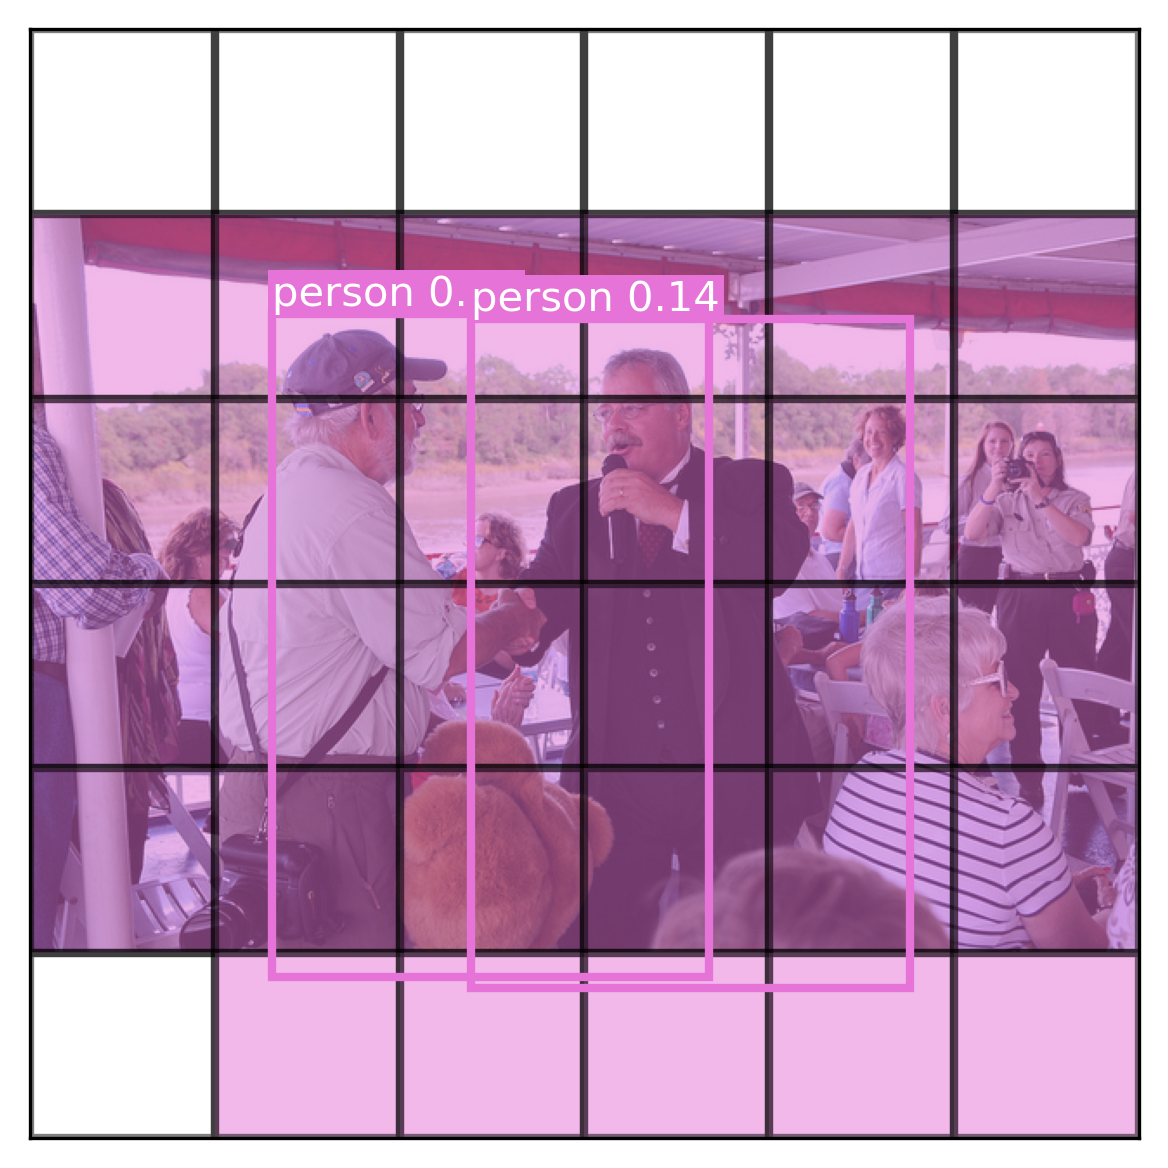

Predicted on: 000000019489.jpg
Detections (conf >=0.1): 2


In [83]:
# Visualize
path = metadata[found_index]["path"]
# max prediction
draw_prediction(path, boxes, classes, cutoff=0.1)
print(f"Predicted on: {os.path.basename(found_path)}")
print(f"Detections (conf >=0.1): {np.sum(boxes[..., 4] >= 0.1)}")  # Quick count

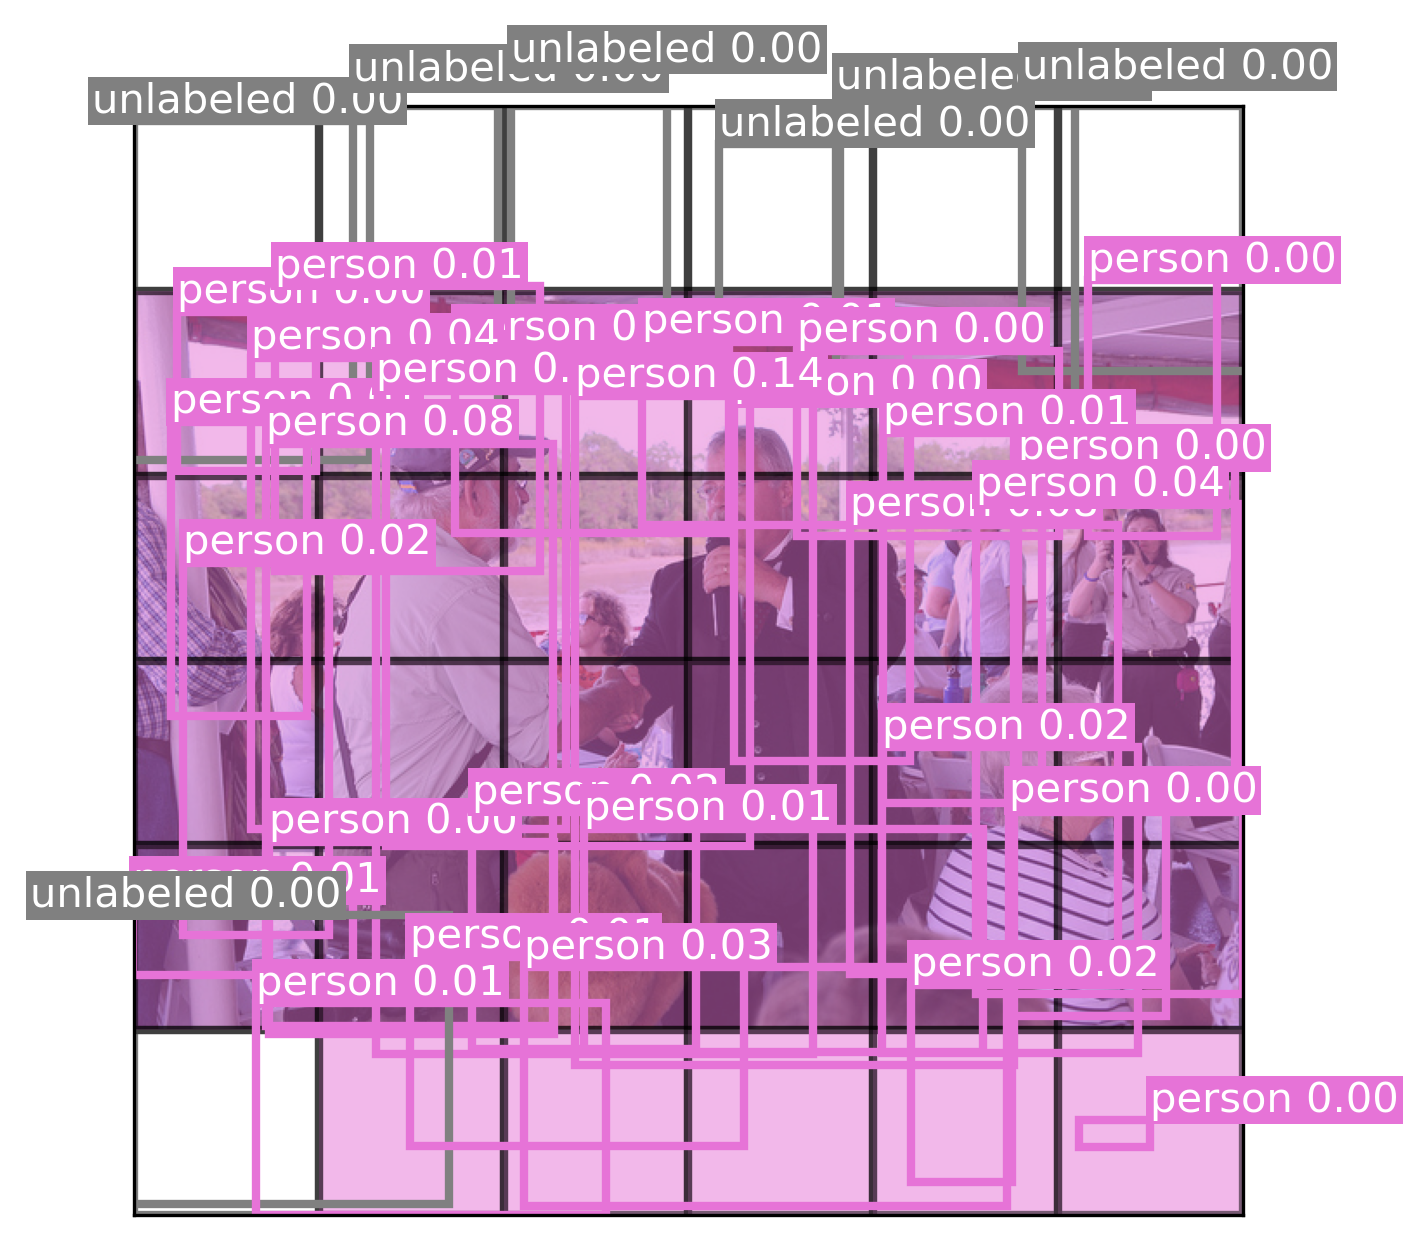

In [84]:
# All prediction
draw_prediction(path, boxes, classes, cutoff=None)

In [85]:
# Loading trained YOLO_V8 model 

from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras_hub.utils import coco_id_to_name  # For GT names

# Load trained model
yolov8_retrained = YOLO("yolov8_retrained.pt")

# Predict on sample
sample = metadata[found_index]
results = yolov8_retrained(sample["path"], conf=0.25, verbose=True)  # Standard conf

# Extract detections
detections = []
for r in results:
    if r.boxes is not None:
        for box in r.boxes:
            if box.conf[0] >= 0.25:
                detections.append({
                    'class_id': int(box.cls[0]),
                    'class_name': yolov8_retrained.names[int(box.cls[0])],
                    'conf': float(box.conf[0]),
                    'box': box.xywhn[0].tolist()  # [x_center, y_center, w, h]
                })

print(f"Retrained YOLOv8: {len(detections)} detections (conf >=0.25)")
print(f"Pred classes: {[d['class_name'] for d in detections]}")

# GT for comparison
gt_classes = [coco_id_to_name(l) for l in sample["labels"]]
print(f"GT classes (unique): {set(gt_classes)}")


image 1/1 /work/Notebooks/coco_dataset/datasets/coco/train2017/000000019489.jpg: 448x640 7 persons, 1 teddy bear, 9.9ms
Speed: 1.2ms preprocess, 9.9ms inference, 5.8ms postprocess per image at shape (1, 3, 448, 640)
Retrained YOLOv8: 8 detections (conf >=0.25)
Pred classes: ['person', 'person', 'person', 'person', 'person', 'teddy bear', 'person', 'person']
GT classes (unique): {'chair', 'bottle', 'person', 'teddy_bear', 'tie'}


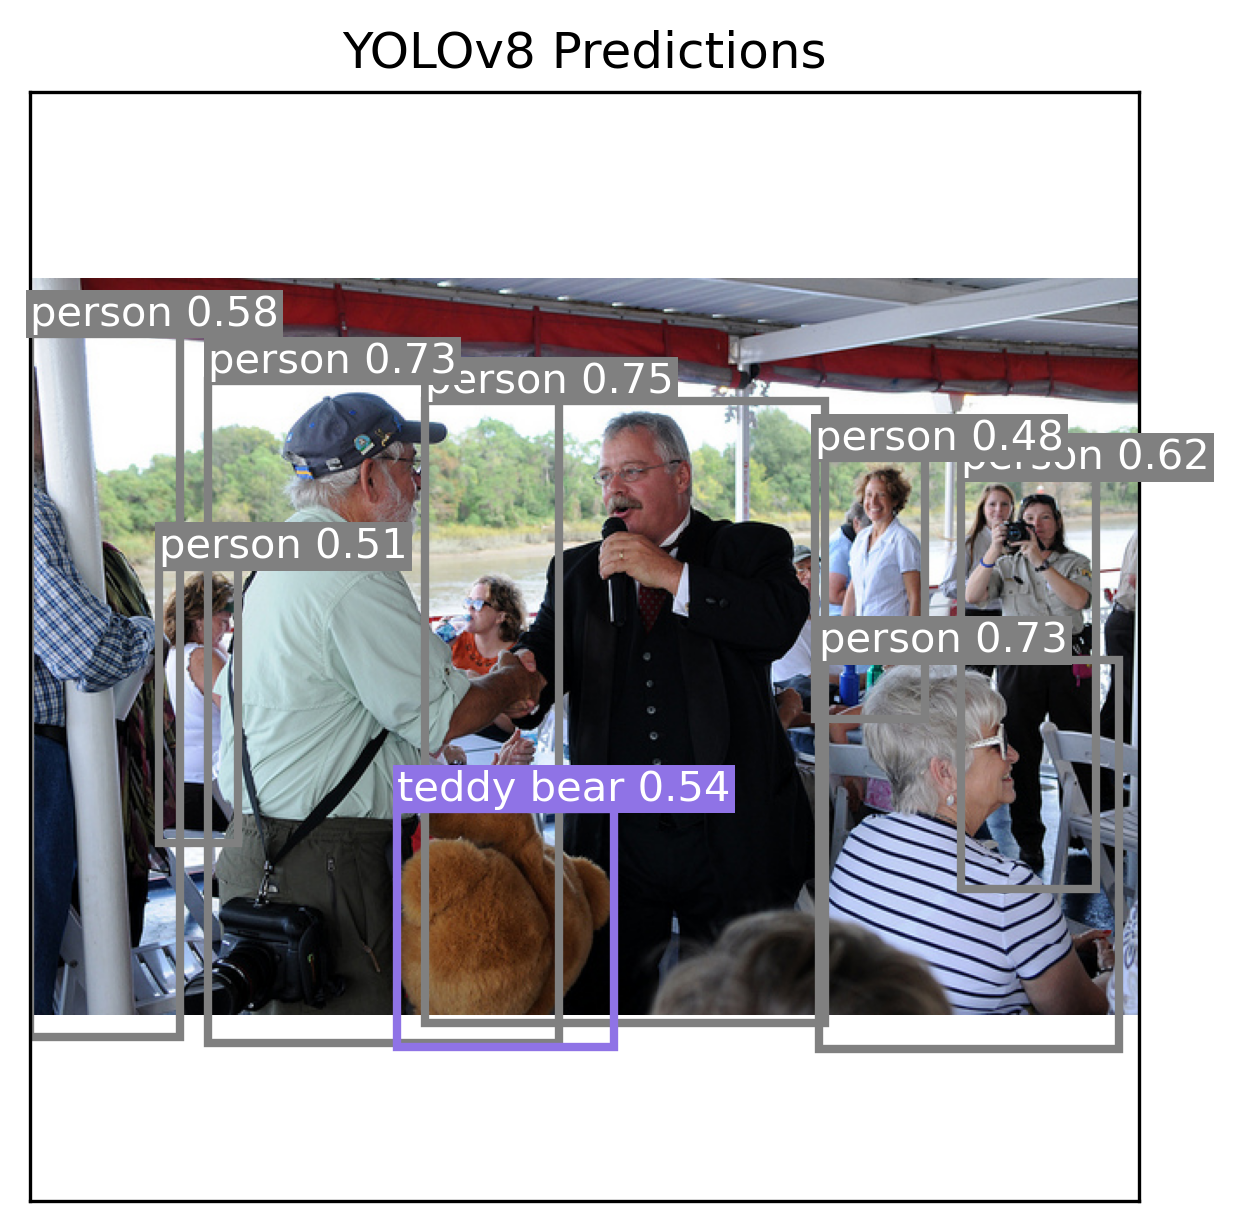

Visualized 8 detections (conf >= 0.25) on 000000019489.jpg


In [86]:
# Visualize YOLOv8 prediction
def draw_yolov8_prediction(image_path, detections, cutoff=0.25):
    fig, ax = plt.subplots(dpi=300)
    draw_image(ax, image_path)  # Handles original image + padding for square view
    
    filtered_dets = [d for d in detections if d['conf'] >= cutoff]
    for d in filtered_dets:
        # Convert center to corner: x_min = x_center - w/2, y_min = y_center - h/2
        x_center, y_center, w, h = d['box']
        x_min = max(0.0, x_center - w / 2)
        y_min = max(0.0, y_center - h / 2)
        # Clip w/h to avoid overflow
        w = min(w, 1.0 - x_min)
        h = min(h, 1.0 - y_min)
        box_corner = [x_min, y_min, w, h]
        
        label = d['class_id']  # Raw COCO ID (or map if needed)
        color = label_to_color(label)
        name = d['class_name']  # Or coco_id_to_name(label) if you prefer
        draw_box(ax, box_corner, f"{name} {d['conf']:.2f}", color)
    
    ax.set_title("YOLOv8 Predictions")
    plt.show()
    
    print(f"Visualized {len(filtered_dets)} detections (conf >= {cutoff}) on {os.path.basename(image_path)}")
    
draw_yolov8_prediction(sample["path"], detections, cutoff=0.25)


In [89]:
import numpy as np

def get_custom_detections(image_path, model, grid_size=6, cutoff=0.25):
    """Predict with custom model and extract normalized detections like YOLOv8."""
    # Your existing prediction setup (adapt from notebook)
    # Load image, predict: pred_output = model.predict(image)  # Shape [1, grid_size, grid_size, 5 + num_labels]
    # Unpack: boxes = pred_output[..., :5]  # [cx, cy, w, h, conf] per grid cell
    # classes = pred_output[..., 5:]  # One-hot or argmax to class_id
    
    # For now, simulate from your earlier arrays (replace with real predict call)
    # Example using pre-computed (from notebook cell 29 or similar)
    index = 0  # metadata[0]
    boxes = box_array[index]  # [6,6,5]
    classes = class_array[index]  # [6,6]
    
    detections = []
    for yi in range(grid_size):
        for xi in range(grid_size):
            box = boxes[yi, xi]  # [cx_off, cy_off, w, h, conf]
            conf = box[4]
            if conf >= cutoff:
                # Convert grid offsets to normalized image coords
                grid_cx, grid_cy, grid_w, grid_h = box[:4]
                norm_box = from_grid((xi, yi), (grid_cx, grid_cy, grid_w, grid_h))  # Your func: [x1, y1, w, h]
                x_center = norm_box[0] + norm_box[2] / 2
                y_center = norm_box[1] + norm_box[3] / 2
                detections.append({
                    'class_id': int(classes[yi, xi]),  # Raw COCO ID
                    'class_name': keras_hub.utils.coco_id_to_name(int(classes[yi, xi])),
                    'conf': float(conf),
                    'box': [x_center, y_center, norm_box[2], norm_box[3]]  # Center format for IoU
                })
    return detections

# Test on sample
sample = metadata[found_index]
custom_detections = get_custom_detections(sample["path"], custom_model)  # Pass model if needed
print(f"Custom YOLO: {len(custom_detections)} detections (conf >=0.25)")
print(f"Custom pred classes: {[d['class_name'] for d in custom_detections]}")

Custom YOLO: 6 detections (conf >=0.25)
Custom pred classes: ['person', 'person', 'person', 'bicycle', 'person', 'person']


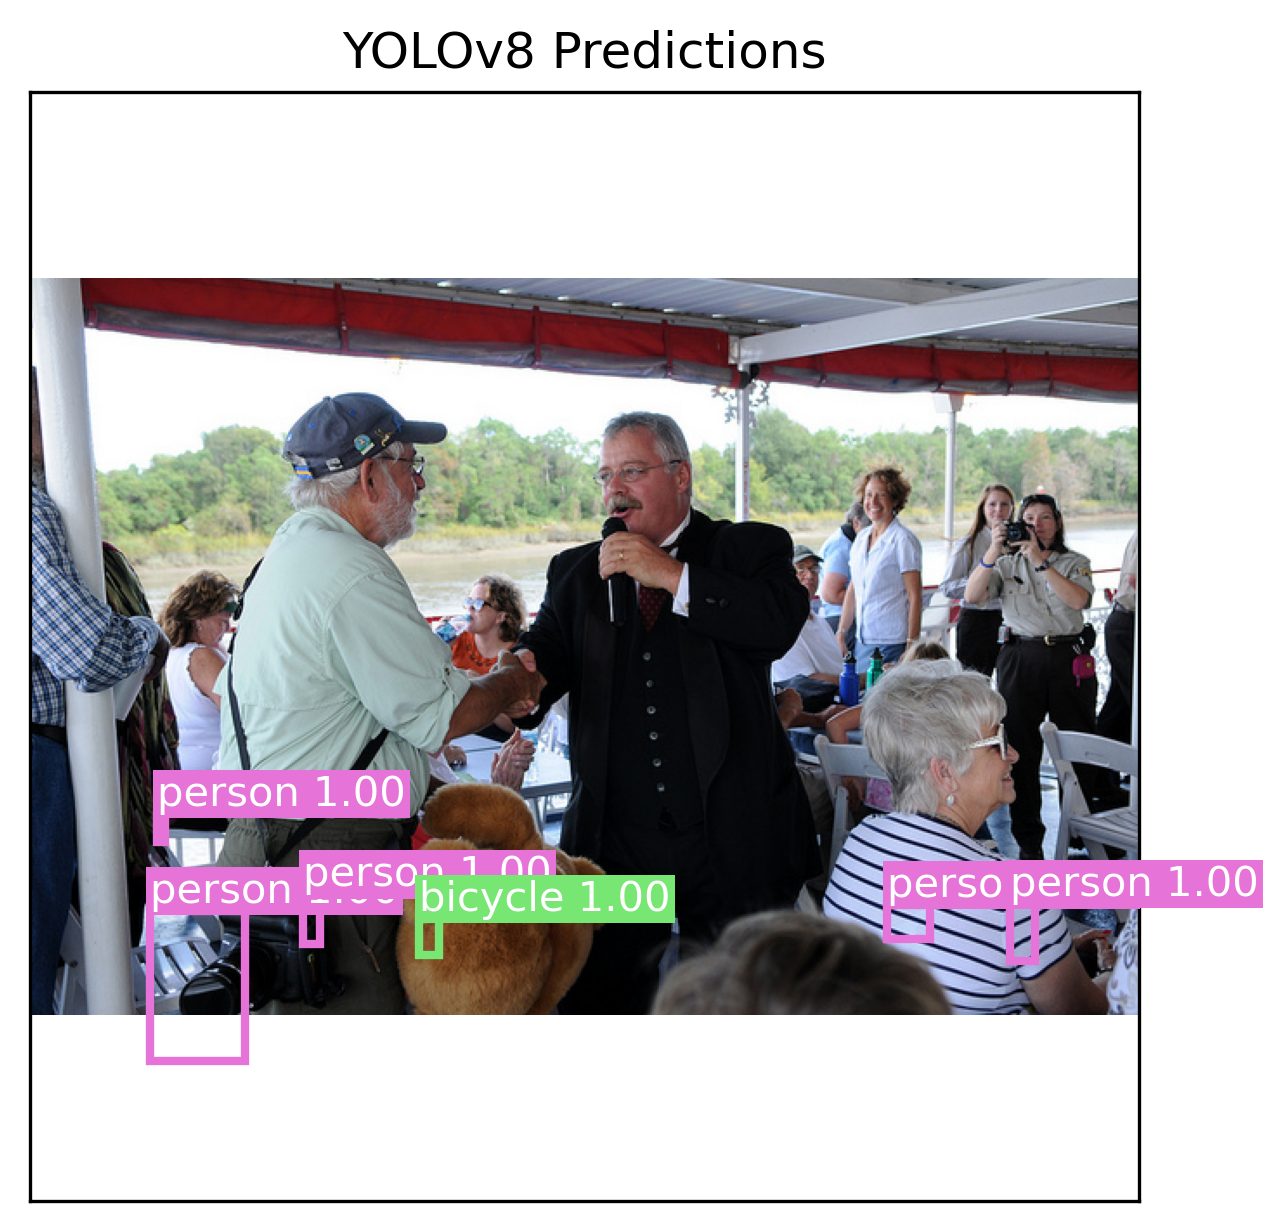

Visualized 6 detections (conf >= 0.25) on 000000019489.jpg


In [90]:
draw_yolov8_prediction(sample["path"], custom_detections, cutoff=0.25)